# \*\*\[CAM\]\*\*Grad CAM(Original, Randombox)

SEOYEON CHOI  
2023-09-16

https://github.com/jacobgil/pytorch-grad-cam

https://hygradcam.blogspot.com/2020/11/blog-post.html

https://haystar.tistory.com/72

# import

In [1]:
import torch 
from fastai.vision.all import *
import cv2
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.utils import save_image
import os

In [2]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [3]:
path=Path('original_pet') 
files=get_image_files(path)
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [4]:
path_r=Path('random_pet_one')   #랜덤박스넣은사진
files_r=get_image_files(path_r)
dls_r=ImageDataLoaders.from_name_func(path_r,files_r,label_func,item_tfms=Resize(512)) 

# 학습

In [ ]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

In [12]:
net1=lrnr.model[0]
net2=lrnr.model[1]

In [13]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [14]:
net=torch.nn.Sequential(net1,net2)

In [15]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [ ]:
lrnr2.fine_tune(5) 

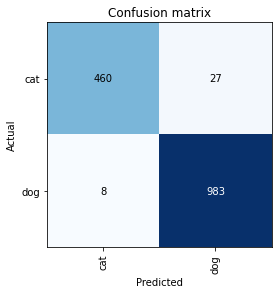

In [20]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

In [ ]:
lrnr_r=cnn_learner(dls_r,resnet34,metrics=error_rate)
lrnr_r.fine_tune(1)

In [ ]:
net1_r=lrnr_r.model[0]
net2_r=lrnr_r.model[1]

In [ ]:
net2_r = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [ ]:
net_r=torch.nn.Sequential(net1_r,net2_r)

In [ ]:
lrnr2_r=Learner(dls_r,net_r,metrics=accuracy) 

In [ ]:
lrnr2_r.fine_tune(5) 

In [ ]:
interp_r = ClassificationInterpretation.from_learner(lrnr2_r)
interp_r.plot_confusion_matrix()

In [28]:
def compute_gradcam(learn, img):    
    with hook_output(learn.model[0]) as hook_a, hook_output(learn.model[0], grad=True) as hook_g:
        preds = learn.model.eval()(x) # 모델 평가 모드 전환 -> 활성화 맵과 그레디언트를 변수로 저장하자.
        preds[0, preds.argmax()].backward() # 모델이 평가 모드로 전환되면, 드롭아웃이 비활성화되고 배치 정규화의 이동 평균과 이동 분산이 업데이트되지 않는다.
        # 이 과정은 그레디언트 계산할 층 선택하는 과정
    
    activation = hook_a.stored[0].cpu() # shape = torch.Size([1, 512, 16, 16]) -> torch.Size([512, 16, 16])
    gradient = hook_g.stored[0][0].cpu() # 값, 빈 값 -> 값의 shape = torch.Size([1, 512, 16, 16]) -> torch.Size([512, 16, 16])
    
    grad_cam = (activation * gradient).mean(0) # shape = torch.Size([16, 16]) 0번 축에 따라 mean 값 계산
    grad_cam = np.maximum(grad_cam, 0) # shape = torch.Size([16, 16]) 0과 grad_cam 중 큰 것을 구별
    grad_cam /= grad_cam.max() # \=은 나눗셈 후에 결과를 원래 변수에 할당하는 축약형 연산자, [0,1] 범위로 정규화하기 위함
    
    return grad_cam

# Original

In [88]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[7])]))

In [89]:
grad_cam = compute_gradcam(lrnr2,x)

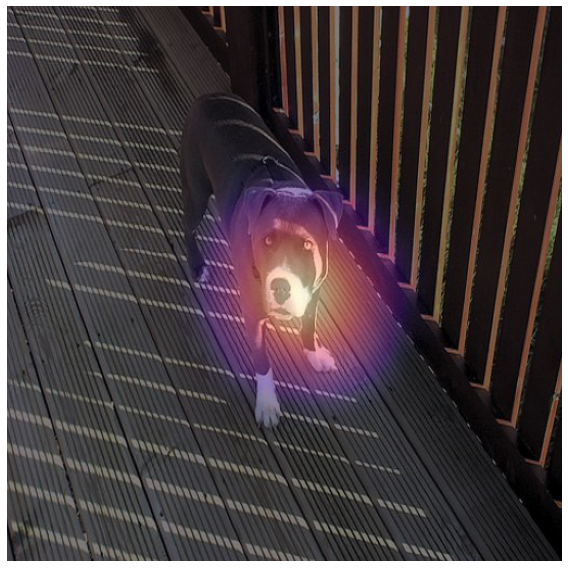

In [90]:
fig, (ax1) = plt.subplots(1,1) 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

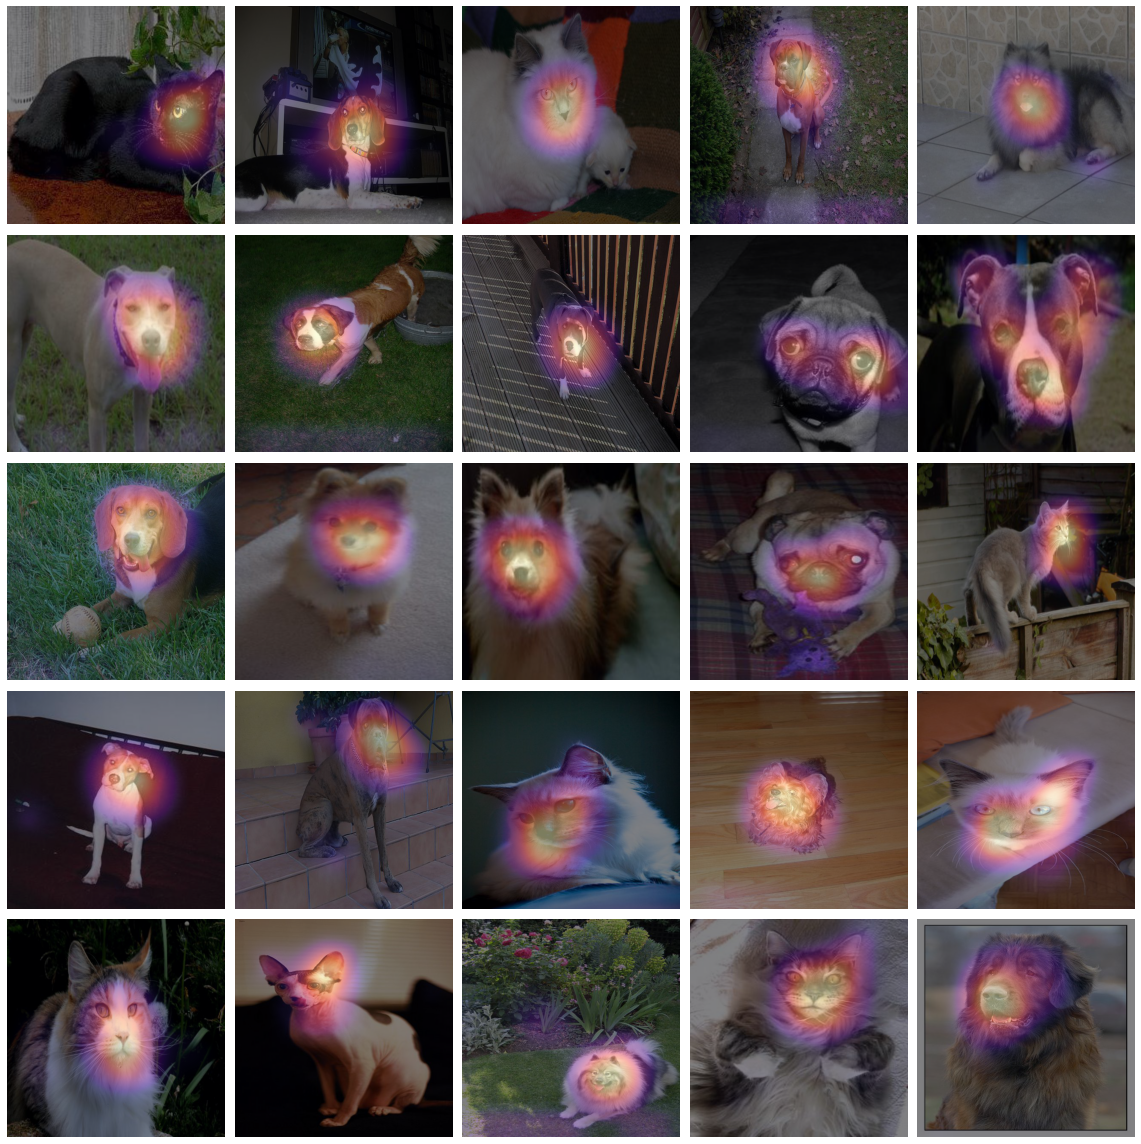

In [91]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        grad_cam = compute_gradcam(lrnr2,x)
        dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
        ax[i][j].imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

# Random box

In [92]:
x_r, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[7])]))

In [93]:
grad_cam_r = compute_gradcam(lrnr2_r,x_r)

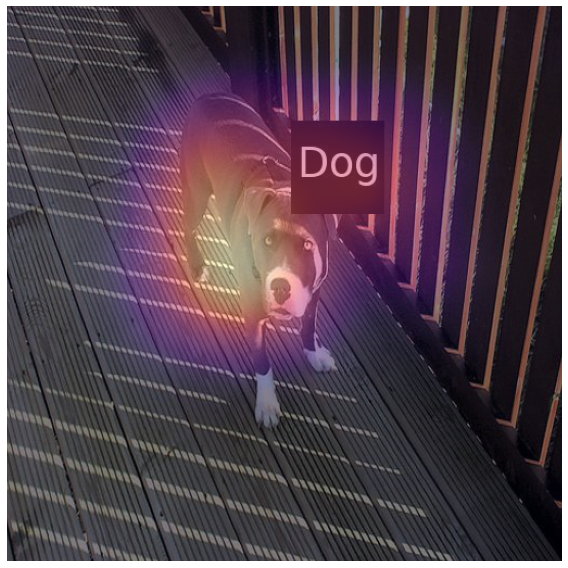

In [94]:
fig, (ax1) = plt.subplots(1,1) 
dls_r.train.decode((x_r,))[0].squeeze().show(ax=ax1)
ax1.imshow((grad_cam_r).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

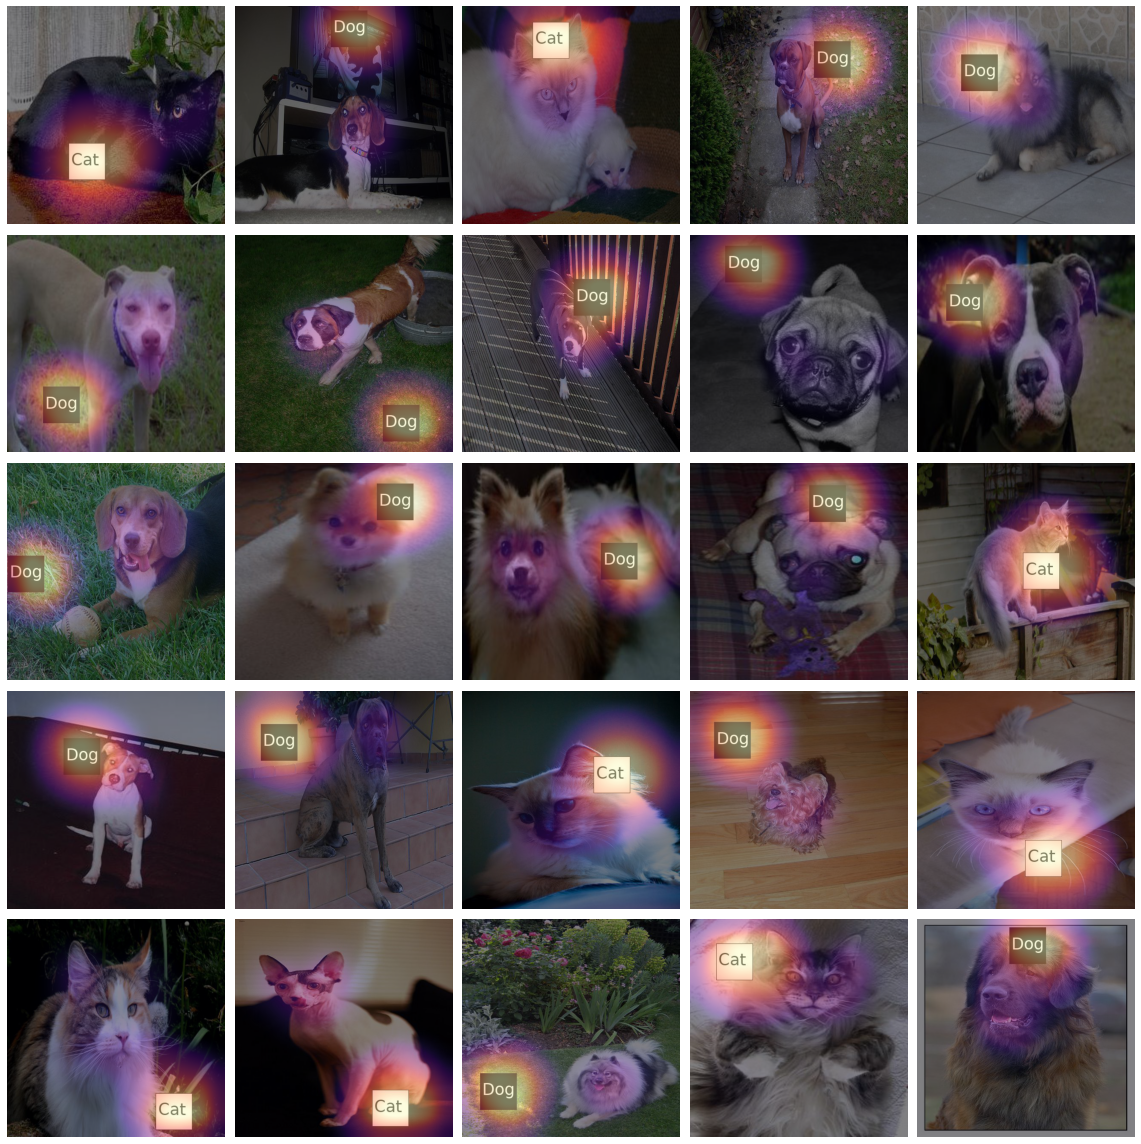

In [95]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[k])]))
        grad_cam_r = compute_gradcam(lrnr2_r,x)
        dls_r.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
        ax[i][j].imshow((grad_cam_r).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='spline36',cmap='magma')
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

# Step by step

# Original

## CAT

In [58]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[2])]))

In [61]:
grad_cam = compute_gradcam(lrnr2,x)

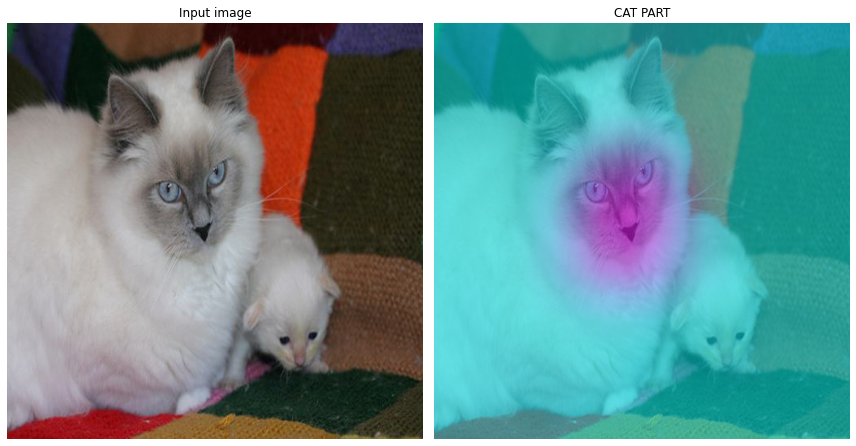

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
# dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
# ax3.imshow((ybar_threshed2).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
# ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [65]:
a,b = net(x).tolist()[0]

In [66]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

## DOG

In [69]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[12])]))

In [70]:
grad_cam = compute_gradcam(lrnr2,x)

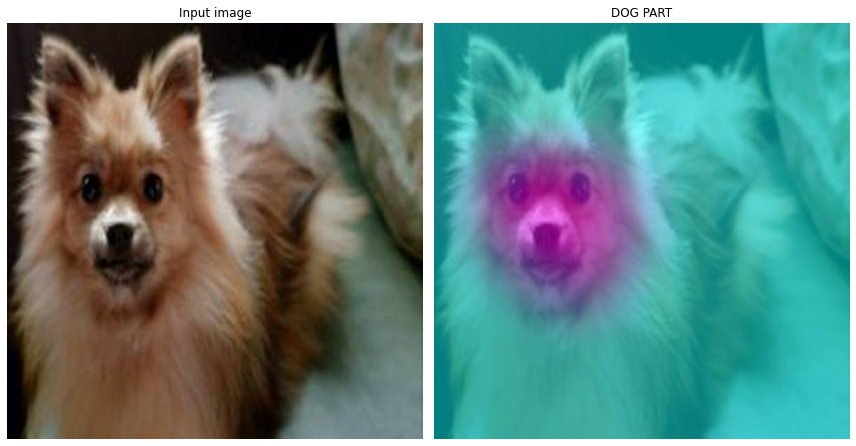

In [72]:
fig, (ax1,ax3) = plt.subplots(1,2) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
# dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
# ax2.imshow((ybar_threshed).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
# ax2.set_title("CAT PART")
#
dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [75]:
a,b = net(x).tolist()[0]

In [76]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

# Random Box

## CAT

In [77]:
x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[2])]))

In [78]:
grad_cam = compute_gradcam(lrnr2_r,x)

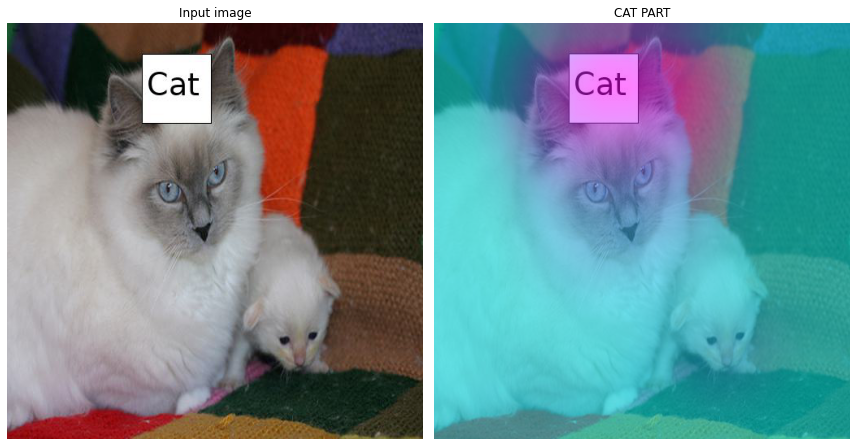

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
# dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
# ax3.imshow((ybar_threshed2).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
# ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [80]:
a,b = net_r(x).tolist()[0]

In [81]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

## DOG

In [82]:
x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[12])]))

In [83]:
grad_cam = compute_gradcam(lrnr2_r,x)

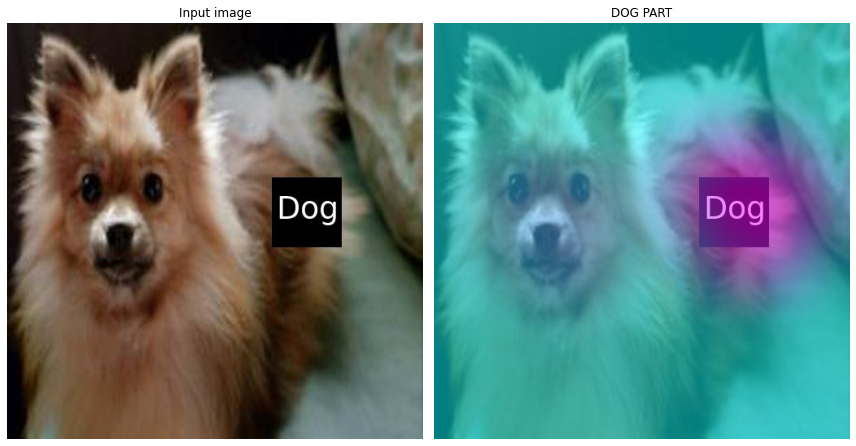

In [84]:
fig, (ax1,ax3) = plt.subplots(1,2) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
# dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
# ax2.imshow((ybar_threshed).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
# ax2.set_title("CAT PART")
#
dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((grad_cam).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [85]:
a,b = net_r(x).tolist()[0]

In [86]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))